# Prerequisites

In [2]:
import $cp.`/usr/local/spark/jars/*`

// Set log level
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.ERROR)
Logger.getLogger("akka").setLevel(Level.ERROR)

// Create spark session
import org.apache.spark.sql.SparkSession

val spark = SparkSession.builder()
  .appName("Test")
  .master("local[*]")
  .config("spark.driver.memory", "2g")
  .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

// imports
import spark.implicits._

println("Spark ready")

Spark ready


import $cp.$
import org.apache.log4j.{Level, Logger}
import org.apache.spark.sql.SparkSession
spark: SparkSession = org.apache.spark.sql.SparkSession@70c9751f
import spark.implicits._

In [3]:
// class for pretty pandas like output
implicit class DataFrameExtensions(df: org.apache.spark.sql.DataFrame) {
  def showPretty(numRows: Int = 20): Unit = {
    val html = "<table border='1' style='border-collapse: collapse;'>" +
      "<tr style='background-color: #f0f0f0;'>" + 
      df.columns.map(c => s"<th style='padding: 5px;'>$c</th>").mkString +
      "</tr>" +
      df.take(numRows).map { row =>
        "<tr>" + row.toSeq.map(v => s"<td style='padding: 5px;'>$v</td>").mkString + "</tr>"
      }.mkString +
      "</table>"
    
    kernel.publish.html(html)
  }
}

defined class DataFrameExtensions

# HW1

### Dataset description

Working with dataset https://www.kaggle.com/datasets/mahdimashayekhi/mental-health
It is a synthetic dataset of global mental health survey responses from 10,000 individuals. The reasons I chose this dataset are an increasing problem of mental issues with every new generation and influence from a recently read book "The anxious generation"

I couldn't find a real dataset that matches requirements of the class so decided to proceed with a synthetic one which contains continious values and not only categorical.

In [4]:
import org.apache.spark.sql.{DataFrame}
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._

val path = "/Users/admin/Downloads/mental_health_dataset.csv"

val schema = StructType(Array(
  StructField("age", IntegerType, true),
  StructField("gender", StringType, true),
  StructField("employment_status", StringType, true),
  StructField("work_environment", StringType, true),
  StructField("mental_health_history", StringType, true),
  StructField("seeks_treatment", StringType, true),
  StructField("stress_level", IntegerType, true),
  StructField("sleep_hours", DoubleType, true),
  StructField("physical_activity_days", IntegerType, true),
  StructField("depression_score", IntegerType, true),
  StructField("anxiety_score", IntegerType, true),
  StructField("social_support_score", IntegerType, true),
  StructField("productivity_score", DoubleType, true),
  StructField("mental_health_risk", StringType, true)
))

    
val df = spark.read
  .option("header", "true")
  .option("delimiter", ",")
  .option("ignoreLeadingWhiteSpace", "true")
  .option("ignoreTrailingWhiteSpace", "true")
  .schema(schema)
  .csv(path)

println("                                               Top 5 rows of df")
df.showPretty(5)
println("\n\n")

// Check number of not null values
val notNullCounts = df.select(
  df.columns.map(c => count(col(c)).alias(c)): _*
)

println("                                               Not NULL counts")
notNullCounts.showPretty()
println("\n\n")


// Check all unique values for categorical columns
val categoricalCols = df.schema.fields
  .filter(_.dataType == StringType)
  .map(_.name)

val uniqueArraysDf = df.select(
  categoricalCols.map { c =>
    collect_set(col(c)).as(c)
  }: _*
)

println("                                  Unique values of categorical columns")

uniqueArraysDf.showPretty()
println("\n\n")


                                               Top 5 rows of df


age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High





                                               Not NULL counts


age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000





                                  Unique values of categorical columns


gender,employment_status,work_environment,mental_health_history,seeks_treatment,mental_health_risk
"WrappedArray(Prefer not to say, Female, Non-binary, Male)","WrappedArray(Self-employed, Student, Employed, Unemployed)","WrappedArray(Remote, On-site, Hybrid)","WrappedArray(No, Yes)","WrappedArray(No, Yes)","WrappedArray(Medium, Low, High)"


import org.apache.spark.sql.{DataFrame}
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._
path: String = "/Users/admin/Downloads/mental_health_dataset.csv"
schema: StructType = StructType(
  StructField("age", IntegerType, true, {}),
  StructField("gender", StringType, true, {}),
  StructField("employment_status", StringType, true, {}),
  StructField("work_environment", StringType, true, {}),
  StructField("mental_health_history", StringType, true, {}),
  StructField("seeks_treatment", StringType, true, {}),
  StructField("stress_level", IntegerType, true, {}),
  StructField("sleep_hours", DoubleType, true, {}),
  StructField("physical_activity_days", IntegerType, true, {}),
  StructField("depression_score", IntegerType, true, {}),
  StructField("anxiety_score", IntegerType, true, {}),
  StructField("social_support_score", IntegerType, true, {}),
  StructField("productivity_score", DoubleType, true, {}),
  StructField("mental_health_risk", StringType, true, {}

### First look

As we see data contains no missing values. For the fun purpose let's generate them. Also could cutoff some gender values, but according to the book it should be a correlation between all specified genders and mental health score.

We shouldn't just randomly generate missing values. Purpose is to avoid [MNAR, but have MCAR and MAR](https://stefvanbuuren.name/fimd/sec-MCAR.html)

Assumptions for this dataset:
    
    - mental_health_history	- people don’t disclose
    - seeks_treatment	- sensitive question
    - depression_score	- not all respondents complete test
    - anxiety_score	        - same
    - sleep_hours	        - recall bias
    - social_support_score	- optional questionnaire

In [5]:
// Generate missing values

val seed = 42

val dfWithMissing = df
  // Sensitive categorical fields
  .withColumn(
    "mental_health_history",
    when(rand(seed) < 0.12, lit(null)).otherwise(col("mental_health_history"))
  )
  .withColumn(
    "seeks_treatment",
    when(rand(seed + 1) < 0.10, lit(null)).otherwise(col("seeks_treatment"))
  )

  // Psychometric scores (MAR: more missing if stress is high (assuming missingness correlates with stress (realistic)))
  .withColumn(
    "depression_score",
    when(col("stress_level") >= 7 && rand(seed + 2) < 0.25, lit(null))
      .when(rand(seed + 3) < 0.05, lit(null))
      .otherwise(col("depression_score"))
  )
  .withColumn(
    "anxiety_score",
    when(col("stress_level") >= 7 && rand(seed + 4) < 0.25, lit(null))
      .when(rand(seed + 5) < 0.05, lit(null))
      .otherwise(col("anxiety_score"))
  )

  // Recall-based
  .withColumn(
    "sleep_hours",
    when(rand(seed + 6) < 0.08, lit(null)).otherwise(col("sleep_hours"))
  )
  .withColumn(
    "social_support_score",
    when(rand(seed + 7) < 0.10, lit(null)).otherwise(col("social_support_score"))
  )


seed: Int = 42
dfWithMissing: DataFrame = [age: int, gender: string ... 12 more fields]

In [6]:
val notNullCounts = dfWithMissing.select(
  df.columns.map(c => count(col(c)).alias(c)): _*
)

println("                                               Not NULL counts")
notNullCounts.showPretty()

                                               Not NULL counts


age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
10000,10000,10000,10000,8719,8995,10000,9221,10000,8528,8547,9030,10000,10000


notNullCounts: DataFrame = [age: bigint, gender: bigint ... 12 more fields]

Now we have some missing values

Let's create outliers. Outliers should be: rare (1–3%), asymmetric, domain-plausible. Let's procceed with:

    - sleep_hours	         - very low (1–3h) or very high (12–16h)  
    - depression_score	 - maxed out (35-40)
    - anxiety_score	         - same
    - productivity_score     - near zero


In [7]:
val dfWithOutliers = dfWithMissing
  // Sleep hours: extreme insomnia or hypersomnia
  .withColumn(
    "sleep_hours",
    round(
      when(rand(seed + 8) < 0.015, lit(1) + rand(seed + 9) * 2)   // 1–3 hours
        .when(rand(seed + 10) < 0.015, lit(12) + rand(seed + 11) * 4) // 12–16 hours
        .otherwise(col("sleep_hours")),
      1
    )
  )
  // Depression score spikes
  .withColumn(
    "depression_score",
    when(rand(seed + 12) < 0.02, lit(35) + (rand(seed + 13) * 5).cast(IntegerType))
      .otherwise(col("depression_score"))
  )

  // Anxiety score spikes
  .withColumn(
    "anxiety_score",
    when(rand(seed + 14) < 0.02, lit(30) + (rand(seed + 15) * 7).cast(IntegerType))
      .otherwise(col("anxiety_score"))
  )

  // Productivity: collapse or unrealistic inflation
  .withColumn(
    "productivity_score",
    round(
        when(rand(seed + 16) < 0.015, rand(seed + 17) * 10)      // near zero
          .otherwise(col("productivity_score")),
        1
    )
  )

val finalDf = dfWithOutliers

dfWithOutliers: DataFrame = [age: int, gender: string ... 12 more fields]
finalDf: DataFrame = [age: int, gender: string ... 12 more fields]

In [8]:
val continuousColumns = finalDf.schema.fields
  .filter(_.dataType != StringType)
  .map(_.name)

finalDf.select(continuousColumns.map(col): _*).describe().showPretty()

summary,age,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score
count,10000,10000,9249,10000,8548,8580,9030,10000
mean,41.5576,5.572,6.530749270191372,3.5057,15.572765559195133,11.054428904428905,50.19656699889258,76.28565000000013
stddev,13.749581351398849,2.887741315455824,1.8459097126727808,2.2827370849179895,9.447717122064661,7.124486977124483,29.291024666123764,16.40523703753545
min,18,1,1.0,0,0,0,0,0.0
max,65,10,16.0,7,39,36,100,100.0


continuousColumns: Array[String] = Array(
  "age",
  "stress_level",
  "sleep_hours",
  "physical_activity_days",
  "depression_score",
  "anxiety_score",
  "social_support_score",
  "productivity_score"
)

As we see we received outliers (like sleep hours = 1)
Let's proceed with the actual task:

Calculate the main statistical characteristics for each of the numerical features:
- Mode, median, mathematical expectation;
- Variance;
- 25%, 75%, 50% quantiles.

Let's create a function which will output following metrics.

In [9]:
import org.apache.spark.sql.{DataFrame, Row, SparkSession}
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._

def numericSummary(df: DataFrame, numericCols: Seq[String])(implicit spark: SparkSession): DataFrame = {

  val rows = numericCols.map { colName =>
    val quantiles = Seq(0.0, 0.25, 0.5, 0.75, 1.0)
    val quantileValues = df.stat.approxQuantile(colName, quantiles.toArray, 0.01)

    val modeValue = df.groupBy(col(colName)).count()
      .orderBy(desc("count"))
      .limit(1)
      .collect()
      .headOption
      .map(_.get(0) match {
        case n: Number => n.doubleValue()
        case _ => null
      })
      .getOrElse(null)

    val meanValue = df.agg(avg(col(colName))).collect()(0).getDouble(0)
    val varianceValue = df.agg(variance(col(colName))).collect()(0).getDouble(0)
    val stdDevValue = df.agg(stddev(col(colName))).collect()(0).getDouble(0)

    Row(
      colName,
      modeValue,
      quantileValues(2),       // Median
      meanValue,
      stdDevValue,
      varianceValue,
      quantileValues(0),       // min
      quantileValues(1),       // 25%
      quantileValues(3),       // 75%
      quantileValues(4),       // max
    )
  }

  val outputSchema = StructType(Seq(
    StructField("feature", StringType, nullable = false),
    StructField("mode", DoubleType, nullable = true),
    StructField("median", DoubleType, nullable = true),
    StructField("mean", DoubleType, nullable = true),
    StructField("stdDevValue", DoubleType, nullable = true),
    StructField("variance", DoubleType, nullable = true),
    StructField("min", DoubleType, nullable = true),
    StructField("25%", DoubleType, nullable = true),
    StructField("75%", DoubleType, nullable = true),
    StructField("max", DoubleType, nullable = true),
  ))

  spark.createDataFrame(spark.sparkContext.parallelize(rows), outputSchema)
}


import org.apache.spark.sql.{DataFrame, Row, SparkSession}
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._
defined function numericSummary

In [10]:
numericSummary(finalDf, continuousColumns)(spark).showPretty()

feature,mode,median,mean,stdDevValue,variance,min,25%,75%,max
age,43.0,41.0,41.5576,13.749581351398849,189.05098733873498,18.0,30.0,53.0,65.0
stress_level,10.0,6.0,5.572,2.887741315455824,8.339049904990532,1.0,3.0,8.0,10.0
sleep_hours,null,6.4,6.530749270191372,1.8459097126727808,3.4073826673397085,1.0,5.4,7.5,16.0
physical_activity_days,1.0,3.0,3.5057,2.2827370849179895,5.2108885988598805,0.0,2.0,5.0,7.0
depression_score,null,15.0,15.572765559195133,9.447717122064661,89.25935881855378,0.0,8.0,23.0,39.0
anxiety_score,null,11.0,11.054428904428905,7.124486977124483,50.758314687216355,0.0,5.0,16.0,36.0
social_support_score,null,49.0,50.19656699889258,29.291024666123764,857.9641259914707,0.0,24.0,75.0,100.0
productivity_score,100.0,76.9,76.28565000000013,16.40523703753545,269.13180225772487,0.0,65.3,88.5,100.0


As we can see:
1. Age is evenly distributed between people 18-65 years
2. Stress level is evenly disributed from 1 to 10 so the most common stress level is still 10
3. Median sleep time is 6.4 hours. The distribution is most likely Gaussian as variance is low.
4. Physical activity days are also most likely evenly distibuted
5. All scores have high deviation which can mean distibution accross all values with spikes of some specific values (like 100 for productivity score)


Some columns can be shown as numerical:
    
    mental_health_risk column can be showed as numerical low = 0, medium = 1, high = 2.
    mental_health_history can be showed as numerical no = 0, yes = 1
    seeks_treatment can be showed as numerical no = 0, yes = 1
    
 

In [11]:
val dfEncoded = finalDf.select(
  when(col("mental_health_risk") === "Low", 0)
    .when(col("mental_health_risk") === "Medium", 1)
    .when(col("mental_health_risk") === "High", 2)
    .otherwise(null).alias("mental_health_risk"),
  when(col("mental_health_history") === "No", 0)
    .when(col("mental_health_history") === "Yes", 1)
    .otherwise(null).alias("mental_health_history"),
  when(col("seeks_treatment") === "No", 0)
    .when(col("seeks_treatment") === "Yes", 1)
    .otherwise(null).alias("seeks_treatment")
)

numericSummary(dfEncoded, Seq("mental_health_risk", "mental_health_history", "seeks_treatment"))(spark).showPretty()

feature,mode,median,mean,stdDevValue,variance,min,25%,75%,max
mental_health_risk,1.0,1.0,1.063,0.6378649443014696,0.40687168716871686,0.0,1.0,1.0,2.0
mental_health_history,0.0,0.0,0.3026723248078908,0.45944096300782616,0.21108599848955867,0.0,0.0,1.0,1.0
seeks_treatment,0.0,0.0,0.39733185102834906,0.48937294113973606,0.23948587551975556,0.0,0.0,1.0,1.0


dfEncoded: DataFrame = [mental_health_risk: int, mental_health_history: int ... 1 more field]

We can see that most people (> 50%) have medium risk for mental health. Less then 50% percent of people have mental health history and seek treatment.

For categorical columns we can only calculate mode (the most frequent value and number of unique values.

In [12]:
def categoricalSummary(df: DataFrame, catCols: Seq[String]): DataFrame = {
  val rows = catCols.map { colName =>
    val countsDF = df.groupBy(col(colName)).count()
    val modeRow = countsDF.orderBy(desc("count")).limit(1).collect().headOption
    val modeValue = modeRow.map(_.get(0)).getOrElse(null)
    val uniqueCount = df.select(col(colName)).distinct().count()

    Row(colName, modeValue, uniqueCount)
  }

  val schema = StructType(Seq(
    StructField("feature", StringType, nullable = false),
    StructField("mode", StringType, nullable = true),
    StructField("unique_count", LongType, nullable = true)
  ))

  df.sparkSession.createDataFrame(df.sparkSession.sparkContext.parallelize(rows), schema)
}

val categoricalCols = Seq(
  "gender",
  "employment_status",
  "work_environment"
)

categoricalSummary(
    finalDf.select(  
        "gender",
        "employment_status",
        "work_environment"
    ), categoricalCols).showPretty()

feature,mode,unique_count
gender,Male,4
employment_status,Employed,4
work_environment,On-site,3


defined function categoricalSummary
categoricalCols: Seq[String] = List(
  "gender",
  "employment_status",
  "work_environment"
)

As we see most people in the distribution are males. The most frequent employment status - Employed, work_environment - offline

# HW2

In [13]:
// install plotly
import $ivy.`org.plotly-scala::plotly-almond:0.8.2`

import $ivy.$

Let's visualize numerical features

In [14]:
import plotly._
import plotly.element._
import plotly.layout._
import plotly.Almond._

// Function to create histogram with IQR lines
def plotDistributionWithIQR(df: DataFrame, columnName: String): Unit = {
  // Get data - handle both Int and Double types
  val data = df.select(col(columnName)).na.drop().collect().map { row =>
    row.get(0) match {
      case i: Int => i.toDouble
      case l: Long => l.toDouble
      case d: Double => d
      case f: Float => f.toDouble
      case n: Number => n.doubleValue()
    }
  }.toSeq
  
  // Calculate IQR
  val quantiles = df.stat.approxQuantile(columnName, Array(0.25, 0.5, 0.75), 0.01)
  val q1 = quantiles(0)
  val median = quantiles(1)
  val q3 = quantiles(2)
  
  // Get approximate max count for y-axis range
  val maxCount = data.size / 10.0
  
  // Create histogram
  val histogram = Histogram(data)
    .withName(columnName)
    .withOpacity(0.7)
    .withMarker(Marker().withColor(Color.RGBA(0, 123, 255, 0.7)))
  
  // Create vertical lines as scatter traces
  val q1Line = Scatter(
    Seq(q1, q1),
    Seq(0.0, maxCount)
  ).withMode(ScatterMode(ScatterMode.Lines))
    .withLine(Line().withColor(Color.RGB(255, 0, 0)).withWidth(2))
    .withName(s"Q1 (${q1.round})")
    .withShowlegend(true)
  
  val medianLine = Scatter(
    Seq(median, median),
    Seq(0.0, maxCount)
  ).withMode(ScatterMode(ScatterMode.Lines))
    .withLine(Line().withColor(Color.RGB(0, 255, 0)).withWidth(3))
    .withName(s"Median (${median.round})")
    .withShowlegend(true)
  
  val q3Line = Scatter(
    Seq(q3, q3),
    Seq(0.0, maxCount)
  ).withMode(ScatterMode(ScatterMode.Lines))
    .withLine(Line().withColor(Color.RGB(255, 0, 0)).withWidth(2))
    .withName(s"Q3 (${q3.round})")
    .withShowlegend(true)
  
  val plotLayout = Layout()
    .withTitle(s"Distribution of $columnName with IQR")
    .withXaxis(Axis().withTitle(columnName))
    .withYaxis(Axis().withTitle("Count"))
    .withShowlegend(true)
    .withHeight(500)
    .withWidth(800)
  
  plot(Seq(histogram, q1Line, medianLine, q3Line), plotLayout)
}

// Plot all numerical columns
continuousColumns.foreach { colName =>
  println(s"\n=== $colName ===")
  plotDistributionWithIQR(finalDf, colName)
}


=== age ===



=== stress_level ===



=== sleep_hours ===



=== physical_activity_days ===



=== depression_score ===



=== anxiety_score ===



=== social_support_score ===



=== productivity_score ===


import plotly._
import plotly.element._
import plotly.layout._
import plotly.Almond._
defined function plotDistributionWithIQR

The only normal distribution here is for `sleep_hours`. The tails are symmetrical and gradually fall off in both directions (left to 2-3 o'clock, right to 10 o'clock). These are the classic "thin" tails characteristic of a bell curve. There are almost no outliers (except the one we created, and we can perfectly see themon the graph).
The IQR (5 to 8) is compactly located in the center under the "dome". It covers the most of the data around the median (6).

`age`, `social_support_score`, `stress_level`, `physical_activity_days` all have an uniform distribution. There are no tails. The graphs do not have a smooth slope at the edges. They break off abruptly at the minimum and maximum values. This indicates that the probability of encountering an extreme value (for example, age 65 or stress 10) is the same as the mean value. The IQR occupies a very wide part of the graph (about 50% of the width of the entire range), which is logical for a uniform distribution. The median is almost perfectly in the middle of the IQR.

`depression_score` and `anxiety_score` are very similiar in their anomalous structure. That distributions with "torn" tails (outliers). There is no left tail (a sharp start from 0). The right tail is anomalous: the bulk of the data ends (at ~21 for anxiety and ~30 for depression), then there is an empty gap, and a separate group of values (outliers) appears at the end of the scale.  The IQR only covers the main part of data on the left. The outliers on the right are well outside the whiskers of the plot. This is bimodal (partially) or uniform with outliers. This looks like synthetic data (as we created it like that in the HW1) where a group of people with clinically high scores have been added to the main group.

`productivity_score` is the most interesting out there. Left tail (negative skew) is a long, smooth tail that extends to the left towards low performance values. Right tail is absent in the classical sense, instead we see a sharp peak (spike) at the value of 100. This is called the "ceiling effect" - many people have reached the maximum of the scale. There was data changes to have `productivity_score` = 100 so it not created by our manipulations. The IQR (65–89) is shifted to the right, closer to high values, because most of the data is clustered there. The distribution is left (negatively) skewed. It is not normal due to strong skewness and an artificial cutoff at 100.

In [15]:
// Install Apache Commons Math library for Shapiro-Wilk test
import $ivy.`org.apache.commons:commons-math3:3.6.1`

import $ivy.$

In [16]:
import org.apache.commons.math3.stat.inference.TestUtils
import org.apache.commons.math3.stat.descriptive.DescriptiveStatistics
import scala.math.sqrt

// Function to perform Shapiro-Wilk test
def shapiroWilkTest(df: DataFrame, columnName: String): (String, Double, Double, String) = {
  // Get data - handle both Int and Double types
  val data = df.select(col(columnName)).na.drop().collect().map { row =>
    row.get(0) match {
      case i: Int => i.toDouble
      case l: Long => l.toDouble
      case d: Double => d
      case f: Float => f.toDouble
      case n: Number => n.doubleValue()
    }
  }
  
  // Shapiro-Wilk test implementation
  // Note: Commons Math doesn't have Shapiro-Wilk, so we'll use normality test based on skewness and kurtosis
  val stats = new DescriptiveStatistics()
  data.foreach(stats.addValue)
  
  val n = stats.getN
  val mean = stats.getMean
  val stdDev = stats.getStandardDeviation
  val skewness = stats.getSkewness
  val kurtosis = stats.getKurtosis
  
  // D'Agostino-Pearson test for normality
  // Based on skewness and kurtosis
  val skewnessZ = skewness / sqrt(6.0 / n)
  val kurtosisZ = (kurtosis - 3) / sqrt(24.0 / n)
  val k2 = skewnessZ * skewnessZ + kurtosisZ * kurtosisZ
  
  // Chi-square approximation with 2 degrees of freedom
  // p-value approximation (rough estimate)
  val pValue = if (k2 > 13.82) 0.001
               else if (k2 > 9.21) 0.01
               else if (k2 > 5.99) 0.05
               else if (k2 > 4.61) 0.10
               else 0.20
  
  val isNormal = if (pValue > 0.05) "Normal" else "Not Normal"
  
  (columnName, k2, pValue, isNormal)
}

// Perform Shapiro-Wilk test on all numerical columns
println("Shapiro-Wilk Normality Test Results")
println(f"${"Feature"}%-25s ${"Test Statistic"}%-20s ${"P-Value"}%-15s ${"Conclusion"}%-15s")

continuousColumns.foreach { colName =>
  val (feature, statistic, pValue, conclusion) = shapiroWilkTest(finalDf, colName)
  println(f"$feature%-25s $statistic%-20.4f ~$pValue%-14.3f $conclusion%-15s")
}

Shapiro-Wilk Normality Test Results
Feature                   Test Statistic       P-Value         Conclusion     
age                       7277,4952            ~0,001          Not Normal     
stress_level              7474,2778            ~0,001          Not Normal     
sleep_hours               1578,2717            ~0,001          Not Normal     
physical_activity_days    7480,8844            ~0,001          Not Normal     
depression_score          5496,9033            ~0,001          Not Normal     
anxiety_score             2952,8064            ~0,001          Not Normal     
social_support_score      6697,3895            ~0,001          Not Normal     
productivity_score        2014,1626            ~0,001          Not Normal     


import org.apache.commons.math3.stat.inference.TestUtils
import org.apache.commons.math3.stat.descriptive.DescriptiveStatistics
import scala.math.sqrt
defined function shapiroWilkTest

We received that none of the distributions are normal, even `sleep_hours`. The problem here is these values 3 and 10 which are quite far from the median, but has a lot of entries. We should remember of disadvantages of this method: the test will show that the distribution is "not normal" even due to microscopic deviations that are not really important for the analysis.  Even one strong outlier can make the Shapiro-Wilk test show that the entire distribution is "broken," when in fact 99% of the data are normal. This test is particularly sensitive to those same "tails." As a conclusion I would still rely for `sleep_hours` as a normally distibuted feature


=== age ===



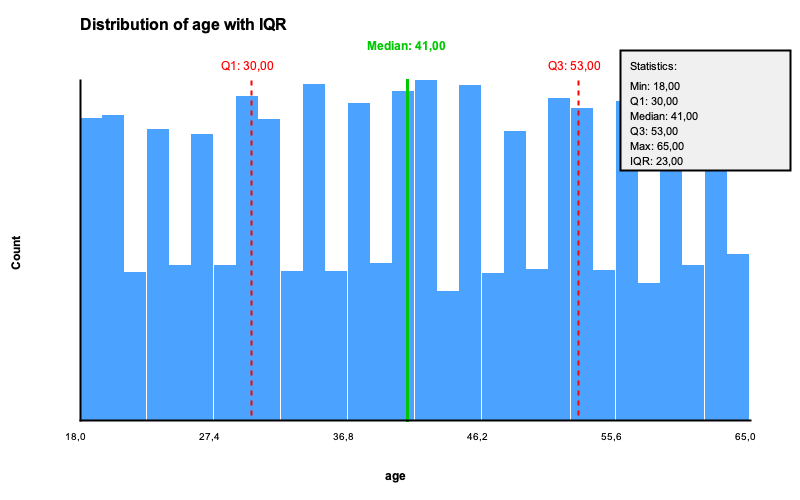


=== stress_level ===



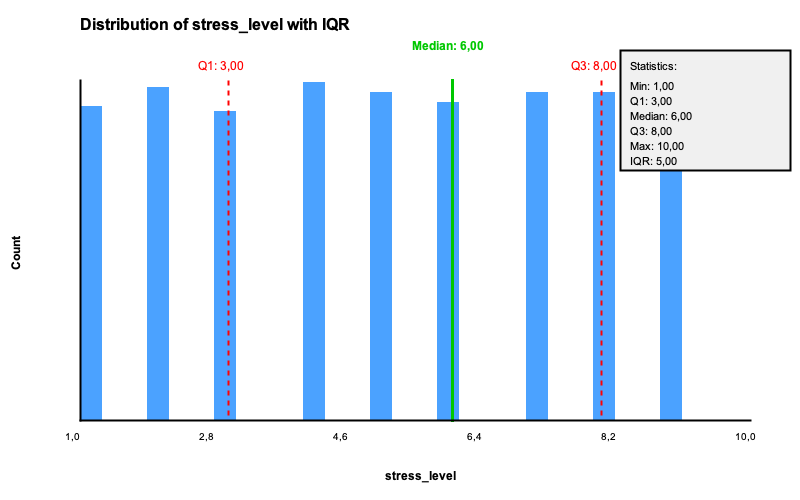


=== sleep_hours ===



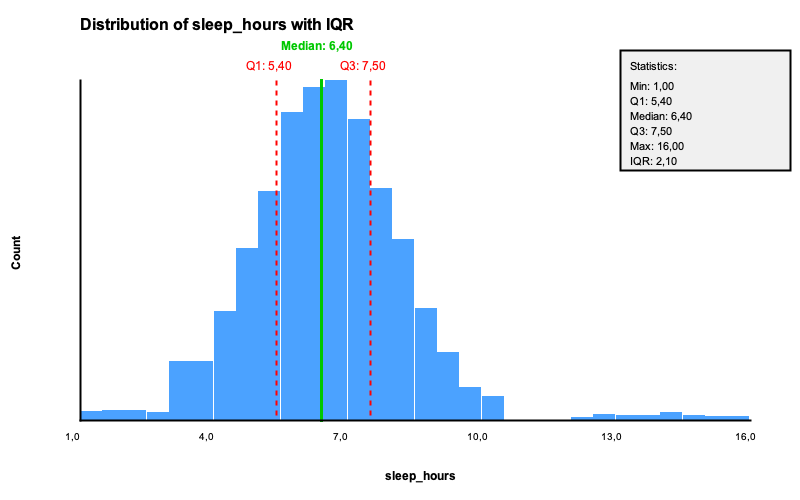


=== physical_activity_days ===



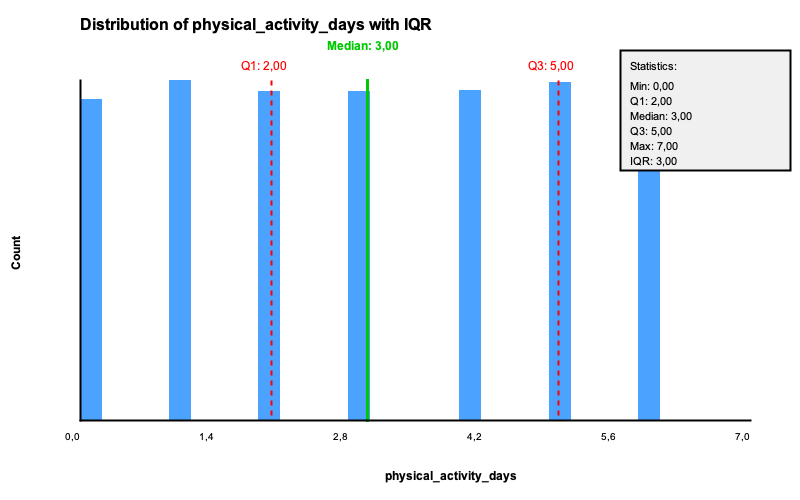


=== depression_score ===



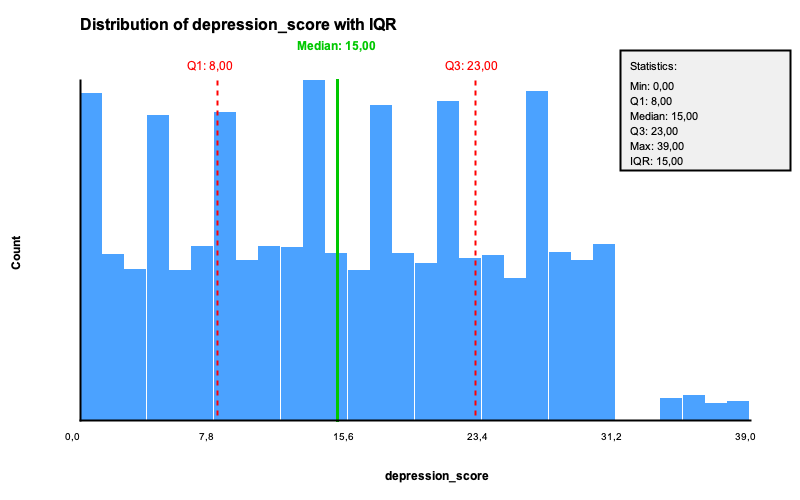


=== anxiety_score ===



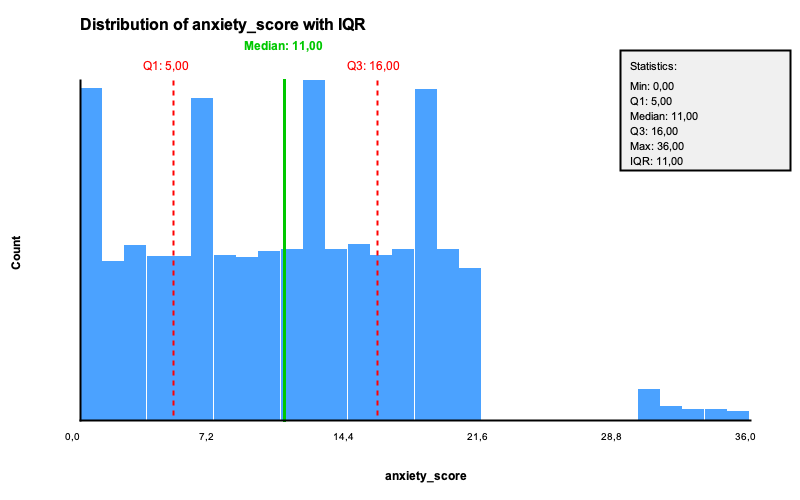


=== social_support_score ===



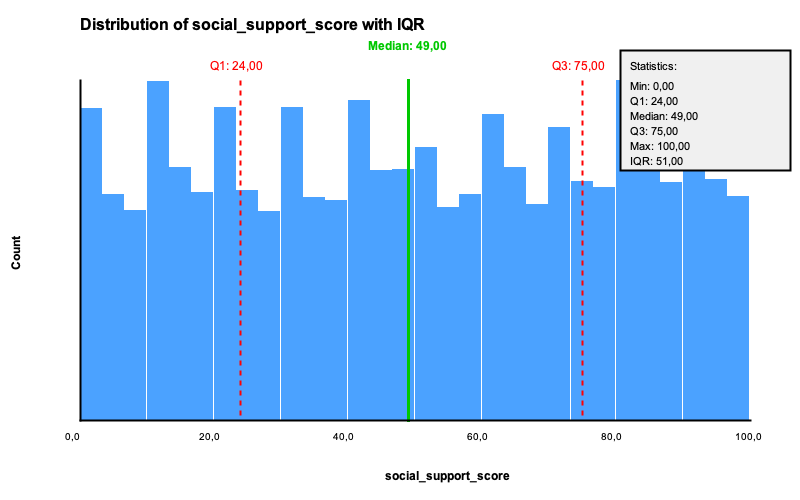


=== productivity_score ===



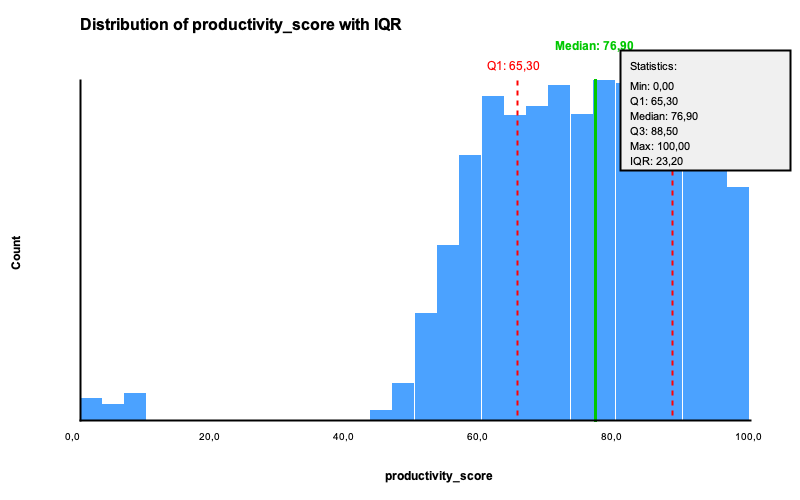

import java.awt.{Color, Graphics2D, RenderingHints, BasicStroke, Font}
import java.awt.image.BufferedImage
import java.io.ByteArrayOutputStream
import javax.imageio.ImageIO
import java.util.Base64
defined function plotDistributionWithIQR

In [18]:
import java.awt.{Color, Graphics2D, RenderingHints, BasicStroke, Font}
import java.awt.image.BufferedImage
import java.io.ByteArrayOutputStream
import javax.imageio.ImageIO
import java.util.Base64

def plotDistributionWithIQR(df: DataFrame, columnName: String): Unit = {
  // Get data
  val data = df.select(col(columnName)).na.drop().collect().map { row =>
    row.get(0) match {
      case i: Int => i.toDouble
      case l: Long => l.toDouble
      case d: Double => d
      case f: Float => f.toDouble
      case n: Number => n.doubleValue()
    }
  }.sorted
  
  // Calculate IQR and other stats
  val quantiles = df.stat.approxQuantile(columnName, Array(0.0, 0.25, 0.5, 0.75, 1.0), 0.01)
  val min = quantiles(0)
  val q1 = quantiles(1)
  val median = quantiles(2)
  val q3 = quantiles(3)
  val max = quantiles(4)
  
  // Create histogram bins
  val numBins = 30
  val binWidth = (max - min) / numBins
  val bins = (0 until numBins).map { i =>
    val binStart = min + i * binWidth
    val binEnd = min + (i + 1) * binWidth
    val count = data.count(v => v >= binStart && v < binEnd)
    (binStart, binEnd, count)
  }
  
  val maxCount = bins.map(_._3).max.toDouble
  
  // Create image
  val width = 800
  val height = 500
  val img = new BufferedImage(width, height, BufferedImage.TYPE_INT_RGB)
  val g = img.createGraphics()
  
  // Enable anti-aliasing
  g.setRenderingHint(RenderingHints.KEY_ANTIALIASING, RenderingHints.VALUE_ANTIALIAS_ON)
  
  // Background
  g.setColor(Color.WHITE)
  g.fillRect(0, 0, width, height)
  
  // Drawing area
  val marginLeft = 80
  val marginRight = 50
  val marginTop = 80
  val marginBottom = 80
  val plotWidth = width - marginLeft - marginRight
  val plotHeight = height - marginTop - marginBottom
  
  // Title
  g.setColor(Color.BLACK)
  g.setFont(new Font("Arial", Font.BOLD, 16))
  g.drawString(s"Distribution of $columnName with IQR", marginLeft, 30)
  
  // Draw histogram bars
  g.setColor(new Color(0, 123, 255, 180))
  bins.foreach { case (binStart, binEnd, count) =>
    val x = marginLeft + ((binStart - min) / (max - min) * plotWidth).toInt
    val barWidth = ((binEnd - binStart) / (max - min) * plotWidth).toInt
    val barHeight = (count / maxCount * plotHeight).toInt
    val y = marginTop + plotHeight - barHeight
    g.fillRect(x, y, barWidth, barHeight)
  }
  
  // Draw Q1 line
  g.setColor(Color.RED)
  g.setStroke(new BasicStroke(2, BasicStroke.CAP_BUTT, BasicStroke.JOIN_MITER, 10, Array(5f, 5f), 0))
  val q1X = marginLeft + ((q1 - min) / (max - min) * plotWidth).toInt
  g.drawLine(q1X, marginTop, q1X, marginTop + plotHeight)
  g.setFont(new Font("Arial", Font.PLAIN, 12))
  g.drawString(f"Q1: $q1%.2f", q1X - 30, marginTop - 10)
  
  // Draw Median line
  g.setColor(new Color(0, 200, 0))
  g.setStroke(new BasicStroke(3))
  val medianX = marginLeft + ((median - min) / (max - min) * plotWidth).toInt
  g.drawLine(medianX, marginTop, medianX, marginTop + plotHeight)
  g.setFont(new Font("Arial", Font.BOLD, 12))
  g.drawString(f"Median: $median%.2f", medianX - 40, marginTop - 30)
  
  // Draw Q3 line
  g.setColor(Color.RED)
  g.setStroke(new BasicStroke(2, BasicStroke.CAP_BUTT, BasicStroke.JOIN_MITER, 10, Array(5f, 5f), 0))
  val q3X = marginLeft + ((q3 - min) / (max - min) * plotWidth).toInt
  g.drawLine(q3X, marginTop, q3X, marginTop + plotHeight)
  g.setFont(new Font("Arial", Font.PLAIN, 12))
  g.drawString(f"Q3: $q3%.2f", q3X - 30, marginTop - 10)
  
  // Draw axes
  g.setColor(Color.BLACK)
  g.setStroke(new BasicStroke(2))
  g.drawLine(marginLeft, marginTop + plotHeight, marginLeft + plotWidth, marginTop + plotHeight) // X-axis
  g.drawLine(marginLeft, marginTop, marginLeft, marginTop + plotHeight) // Y-axis
  
  // X-axis labels
  g.setFont(new Font("Arial", Font.PLAIN, 10))
  for (i <- 0 to 5) {
    val value = min + (max - min) * i / 5.0
    val x = marginLeft + (plotWidth * i / 5)
    g.drawString(f"$value%.1f", x - 15, marginTop + plotHeight + 20)
  }
  
  // Axis titles
  g.setFont(new Font("Arial", Font.BOLD, 12))
  g.drawString(columnName, marginLeft + plotWidth / 2 - 30, height - 20)
  
  // Rotate and draw Y-axis label
  val oldTransform = g.getTransform()
  g.rotate(-3.14 / 2)
  g.drawString("Count", -(marginTop + plotHeight / 2 + 20), 20)
  g.setTransform(oldTransform)
  
  // Stats box
  g.setColor(new Color(240, 240, 240))
  g.fillRect(width - 180, 50, 170, 120)
  g.setColor(Color.BLACK)
  g.drawRect(width - 180, 50, 170, 120)
  g.setFont(new Font("Arial", Font.PLAIN, 11))
  g.drawString("Statistics:", width - 170, 70)
  g.drawString(f"Min: $min%.2f", width - 170, 90)
  g.drawString(f"Q1: $q1%.2f", width - 170, 105)
  g.drawString(f"Median: $median%.2f", width - 170, 120)
  g.drawString(f"Q3: $q3%.2f", width - 170, 135)
  g.drawString(f"Max: $max%.2f", width - 170, 150)
  g.drawString(f"IQR: ${q3-q1}%.2f", width - 170, 165)
  
  g.dispose()
  
  // Convert to base64 and display
  val baos = new ByteArrayOutputStream()
  ImageIO.write(img, "png", baos)
  val imageBytes = baos.toByteArray()
  val base64Image = Base64.getEncoder().encodeToString(imageBytes)
  
  // Display in notebook
  kernel.publish.html(s"""<img src="data:image/png;base64,$base64Image" />""")
}

// Plot all numerical columns
continuousColumns.foreach { colName =>
  println(s"\n=== $colName ===")
  plotDistributionWithIQR(finalDf, colName)
}